In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('MaunaLoaDailyTemps.csv', index_col='DATE', parse_dates=True)

In [3]:
df.shape

(1825, 5)

In [4]:
df.isnull().sum()
df = df.dropna()

In [5]:
df.head()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


<AxesSubplot:xlabel='DATE'>

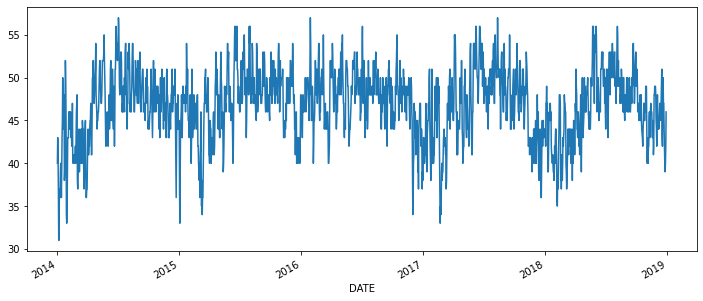

In [6]:
df['AvgTemp'].plot(figsize=(12,5))

Check for stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-value : ", dftest[1])
    print("3. Num of lags : ", dftest[2])
    print("4. Num of observations used for ADF regression and critical values calculation : ", dftest[3])
    print("Critical Values : ")
    for key , val in dftest[4].items():
        print("\t" ,key, ": ", val)

c:\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
ad_test(df['AvgTemp'])

1. ADF :  -6.554680125068781
2. P-value :  8.67593748019951e-09
3. Num of lags :  12
4. Num of observations used for ADF regression and critical values calculation :  1808
Critical Values : 
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


Figure out order of ARIMA model

In [11]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [12]:
stepwise_fit = auto_arima(df['AvgTemp'], trace=True, 
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8344.288, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10347.755, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8365.701, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9136.225, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19192.139, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8355.947, Time=1.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8356.308, Time=1.09 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8347.323, Time=1.80 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8318.557, Time=2.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8330.189, Time=2.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8310.793, Time=2.61 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=8332.018, Time=3.07 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8317.482, Time=3.34 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=8306.457, Time=3.10 sec
 ARIMA(1,0,4)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.782
Date:                Tue, 04 Jul 2023   AIC                           8295.564
Time:                        05:01:28   BIC                           8339.621
Sample:                             0   HQIC                          8311.817
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3453      0.392      3.428      0.001       0.576       2.114
ar.L1          0.9711      0.008    115.044      0.000       0.955       0.988
ma.L1         -0.1242      0.024     -5.202      0.000      -0.171      -0.077
ma.L2         -0.2174      0.024     -8.947      0.000      -0.265      -0.170
ma.L3         -0.2037      0.024     -8.483      0.000      -0.251      -0.157
ma.L4         -0.1358      0.023     -5.957      0.000      -0.180      -0.091
ma.L5         -0.0472      0.024     -1.937      0.053      -0.095       0.001
sigma2         5.4897      0.172     31.995      0.000       5.153       5.826
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using auto_arima funciton we are able to calculate optimal values of p,d,q to be used as in the best ARIMA model for final predictions

Spliting

In [14]:
print(df.shape)
train = df.iloc[:-30]
test = df.iloc[-30:]
print(train.shape)
print(test.shape)

(1821, 5)
(1791, 5)
(30, 5)


In [55]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train['AvgTemp'], order=(1,0,5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Tue, 04 Jul 2023   AIC                           8156.395
Time:                        05:44:31   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Making predictions on test set

In [57]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, type='levels')
pred.index = df.index[start:end+1] # indexing wrt to dates
print(pred)

DATE
2018-12-01    44.754109
2018-12-02    44.987795
2018-12-03    45.388741
2018-12-04    45.721545
2018-12-05    45.863733
2018-12-06    45.874126
2018-12-07    45.884370
2018-12-08    45.894466
2018-12-09    45.904417
2018-12-10    45.914225
2018-12-11    45.923891
2018-12-12    45.933418
2018-12-13    45.942809
2018-12-14    45.952063
2018-12-15    45.961185
2018-12-16    45.970175
2018-12-17    45.979036
2018-12-18    45.987769
2018-12-19    45.996377
2018-12-20    46.004861
2018-12-21    46.013222
2018-12-22    46.021463
2018-12-23    46.029586
2018-12-24    46.037591
2018-12-25    46.045481
2018-12-26    46.053258
2018-12-27    46.060923
2018-12-28    46.068477
2018-12-29    46.075922
2018-12-30    46.083261
Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='DATE'>

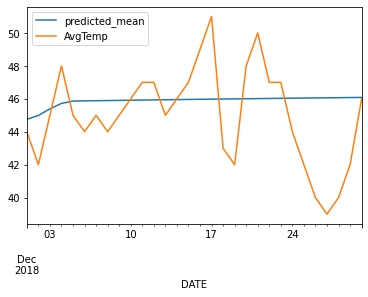

In [58]:
pred.plot(legend=True)
test['AvgTemp'].plot(legend=True)

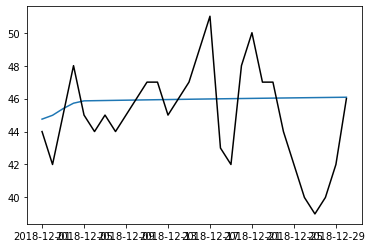

In [59]:
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test['AvgTemp'],color='black')

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['AvgTemp']))
print(rmse)

3.000463843212972
